In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-05-24 08:03:59--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: 'names.txt'

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.01s   

2024-05-24 08:04:00 (16.8 MB/s) - 'names.txt' saved [228145/228145]



In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [6]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


## Linear

In [8]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out)) /fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

## Batch Normalisation

In [9]:
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdims = True)
            xvar = x.var(0, keepdims = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffer
        if self.training:
            with torch.no_grad():
                self.running_mean = (1- self.momentum) * self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum*xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

## Activation

In [10]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

## Embedding and Flattening Operations and Sequential

In [11]:
class Embedding:
    def __init__(self, num_embeddings, embedding_data):
        self.weight = torch.randn((num_embeddings, embedding_data))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return  []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [12]:
torch.manual_seed(42)

In [13]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameters init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


### Debugging

In [14]:
ix = torch.randint(0, Xtr.shape[0], (4, ))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 12, 15],
        [ 0,  0,  0,  0,  0,  0, 20,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 11]])

In [15]:
model.layers[0].out.shape # output of the embedding layer

torch.Size([4, 8, 10])

In [16]:
model.layers[1].out.shape # output of Flatten layer

torch.Size([4, 80])

In [17]:
model.layers[2].out.shape # output of Linear Layer

torch.Size([4, 200])

In [18]:
max_steps = 200_000
batch_size = 32
lossi = []
set_ix = set()

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # tracking the ix which have been used
    # set_ix.add([v.item() for v in ix])
    
    # forward pass
    #  x = Xb # due to the new Embedding and Flatten class, 
    # we can now kickstart the NN with x = Xb and 
    # the rest will be done in the for loop with the layers module
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10_000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
#     break

      0/ 200000: 3.2890
  10000/ 200000: 2.1019
  20000/ 200000: 1.8017
  30000/ 200000: 2.1541
  40000/ 200000: 1.9434
  50000/ 200000: 2.0993
  60000/ 200000: 2.4388
  70000/ 200000: 1.9126
  80000/ 200000: 2.1679
  90000/ 200000: 2.3918
 100000/ 200000: 1.5622
 110000/ 200000: 2.0194
 120000/ 200000: 2.2996
 130000/ 200000: 2.2614
 140000/ 200000: 2.3370
 150000/ 200000: 2.0491
 160000/ 200000: 1.7646
 170000/ 200000: 2.2587
 180000/ 200000: 1.7975
 190000/ 200000: 1.9115


Can Get rid of the 
```
plt.plot(lossi)
```
As we now have a much better plot

## Getting the loss to be more interpretable

In [19]:
torch.tensor(lossi).view(-1, 1000).mean(1).shape

torch.Size([200])

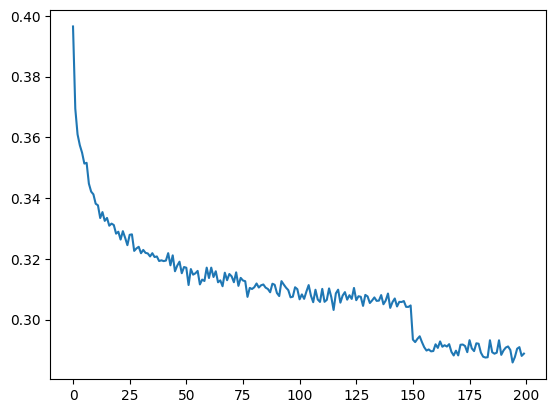

In [20]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

We see the learning rate decay at 150

In [21]:
# put layer into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [22]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': {Xtr, Ytr},
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9192137718200684
val 2.0341391563415527


### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.106
- context: 3 -> 8 (22K params): train 1.918, val 2.027

In [23]:
# sample from the model

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim = 1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples = 1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

ari.
kya.
kylek.
tiskin.
porbyn.
abib.
merigglynn.
loriel.
jiildy.
davry.
olby.
aerik.
milahny.
evelie.
breckan.
misse.
josumar.
rami.
ahli.
jordel.
